In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_51/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.3.0 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.10.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# APIs - Práctica Guiada III

<a id="section_toc"></a> 
## Tabla de Contenidos

[1- Intro](#section_intro)

$\hspace{.5cm}$[1.1- La librería requests](#section_requests)

[2- Formando un DataFrame](#section_df)

$\hspace{.5cm}$[2.1- Parseando un JSON con Pandas](#section_json_normalize)

$\hspace{.5cm}$[2.2- Data Wrangling](#section_data_wrangling)

[3- Paginado: cómo armar el DataFrame final](#section_paginado)

---

<a id="section_intro"></a> 
###  1- Intro
[volver a TOC](#section_toc)

El objetivo de esta práctica guiada es generar el dataset que utilizaremos en el ejercicio de la clase. Para ello, utilizaremos funcionalidades un poco más avanzadas de la librería `requests`, la cual tiene una reputación notable como una de las librerías más "Pythonicas" que existen.

<a id="section_requests"></a> 
#### 1.1- La librería requests
[volver a TOC](#section_toc)

Como explicamos en la clase teórica, el protocolo HTTP nos permite emplear distintas "acciones" por medio de las requests HTTP. La librería requests es un paquete de Python que contiene métodos sencillos y lineales para ejecutar estas Requests (GET, POST, PUT, DELETE).

Cuando una API no tiene una librería desarrollada para consumirse (o incluso cuando la tiene pero nos resulta incómoda o restrictiva), la librería requests nos permite directamente traer los resultados de ejecutar una HTTP request al endpoint que deseemos, siempre y cuando tengamos la posibilidad de acceder a él (lógicamente no es muy sencillo intentar mandar una DELETE request a la API de Mercadolibre, por ejemplo, a menos que seamos los propietarios de una determinada publicación). 

Para traernos datos, lo más habitual, y lo que usaremos en esta práctica, es una request tipo GET. Si esta request es exitosa, nos traerá un mensaje (hoy en día lo más común es el formato JSON) con la información de la página que pedimos ver. A continuación, veamos un ejemplo sencillo:

In [2]:
from datetime import datetime
import requests
import json
import pandas as pd

url = "https://api.mercadolibre.com/sites/MLA/search?q=nintendo+switch&condition=new&limit=50"  # Endpoint a consultar
response = requests.get(url)

La respuesta a una request es un objeto tipo `requests.models.Response`. Este tipo de objetos contiene, además del texto del mensaje de respuesta, un código de status. Podemos ver en esta imagen el significado de distintos códigos de respuesta:

<img src='./img/statuscode2.jpg' align='center'/>

Para una request de tipo GET, un código 200 significa que todo está bien. Veamos qué status obtenemos para nuestra consulta a Mercadolibre:

In [3]:
print("Status Code:", response.status_code)

Status Code: 200


Veamos ahora el encabezado de la respuesta. De aquí podemos obtener varios datos interesantes, como cuándo fue hecha la request y qué encoding tiene el mensaje que nos devuelve en la respuesta.

In [4]:
print(response.headers)

{'Content-Type': 'application/json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Date': 'Wed, 02 Feb 2022 14:41:32 GMT', 'cache-control': 'max-age=300, stale-while-revalidate=150, stale-if-error=600', 'vary': 'Accept,Accept-Encoding', 'etag': 'c1229b18e72f6cc7d46eb68623caa051', 'X-Content-Type-Options': 'nosniff', 'X-Request-Id': 'dbe48467-bd46-45c3-b4ea-fbfd8effebcd', 'X-Frame-Options': 'DENY', 'X-XSS-Protection': '1; mode=block', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Headers': 'Content-Type', 'Access-Control-Allow-Methods': 'PUT, GET, POST, DELETE, OPTIONS', 'Access-Control-Max-Age': '86400', 'X-Cache': 'Miss from cloudfront', 'Via': '1.1 05a4a9640af10258c45819b63c421392.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'EZE51-C1', 'X-Amz-Cf-Id': 'md_JzXHLqOymNKsVkDogYaT7pt7gd0rVDalsjqMZQZ2zAJ9h7IzqjQ=='}


---

En el atributo `response.text` de la respuesta, obtenemos el contenido del mensaje. Por ser esta una request tipo get, pueden hacer la prueba de ingresar a la URL de la request en su navegador, y observarán el json del resultado que aquí obtenemos en forma programática.

El texto viene como un string, pero queremos poder tratarlo como una estructura de datos, con lo cual vamos a parsear el json con la librería `json` de Python. Esta librería viene con cualquier instalación de Python, por lo cual no requiere setup adicional. `json.loads()` convertirá la respuesta en objetos nativos de Python (diccionarios y listas), con el fin de poder armar nuestro dataset.

En el caso particular de la respuesta de Mercadolibre, dentro del json encontramos una clave "results", en la cual encontraremos toda publicación perteneciente a la respuesta. Vamos a quedarnos con los resultados en nuestra variable `results`.

In [25]:
data = json.loads(response.text)

results=data["results"]

# print(results[0])

<a id="section_df"></a> 
###  2- Formando un DataFrame
[volver a TOC](#section_toc)

Para el ejercicio de esta clase, vamos a querer usar un DataFrame de publicaciones de Mercadolibre con el fin de predecir la cantidad de unidades vendidas. Para ello, queremos formar un DataFrame de pandas y formar un CSV. Usar el constructor de DataFrame sobre nuestra variable `results` tiene varias limitaciones muy serias, que iremos resolviendo conforme avancemos en la práctica, vamos a ver algunas de ellas a continuación.

In [6]:
df=pd.DataFrame(results)
df.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,tags,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,order_backend,differential_pricing
0,MLA1110619955,MLA,Nintendo Switch Oled 64gb Standard Color Blan...,"{'id': 82274172, 'permalink': 'http://perfil.m...",94499.0,"{'id': 'MLA1110619955', 'prices': [{'id': '17'...",None,ARS,8,33,...,"[good_quality_picture, good_quality_thumbnail,...",True,True,None,None,None,None,None,1,NaN
1,MLA1112386883,MLA,Nintendo Switch Oled 64gb Standard Color Rojo...,"{'id': 499786196, 'permalink': 'http://perfil....",94499.0,"{'id': 'MLA1112386883', 'prices': [{'id': '10'...",None,ARS,2,26,...,"[good_quality_picture, good_quality_thumbnail,...",True,True,None,None,None,None,None,2,NaN
2,MLA934084570,MLA,Nintendo Switch 32gb Standard Color Gris Y Negro,"{'id': 69526727, 'permalink': 'http://perfil.m...",78999.0,"{'id': 'MLA934084570', 'prices': [{'id': '22',...",None,ARS,9,7,...,"[good_quality_picture, good_quality_thumbnail,...",True,True,None,None,None,None,None,3,NaN
3,MLA1120836702,MLA,Nintendo Switch Lite 32gb Standard Color Coral,"{'id': 499786196, 'permalink': 'http://perfil....",48999.0,"{'id': 'MLA1120836702', 'prices': [{'id': '2',...",None,ARS,6,4,...,"[loyalty_discount_eligible, brand_verified, ex...",True,True,None,None,None,None,None,4,NaN
4,MLA1120162980,MLA,Nintendo Switch Lite 32gb Standard Color Azul,"{'id': 69526727, 'permalink': 'http://perfil.m...",48999.0,"{'id': 'MLA1120162980', 'prices': [{'id': '2',...",None,ARS,10,0,...,"[brand_verified, extended_warranty_eligible, g...",True,True,None,None,None,None,None,5,NaN


En este primer resultado podemos observar varios de los problemas de los que hablábamos anteriormente:
* Muchas de nuestras columnas son diccionarios. ¿Cómo podemos acceder a los campos en cada uno?
* Sólo tenemos 50 registros. ¿Qué pasa si modificamos el parámetro `limit` en nuestra request?
* Muchas de las publicaciones que vemos no refieren al producto que buscamos, sino que nos hablan de accesorios para el mismo. ¿Es posible filtrar estas respuestas?

<a id="section_json_normalize"></a> 
#### 2.1- Parseando un JSON con Pandas
[volver a TOC](#section_toc)

Afortunadamente, como dijimos antes, el formato JSON se ha vuelto un estándar ampliamente difundido en los respuestas de APIs y, como tal, Pandas tiene su propia implementación para leer información de JSONs y expandir los subcampos.

Por todo lo susodicho, la función `json_normalize` de Pandas resuelve en forma sencilla y completa el primero de los tres problemas que teníamos anteriormente. Veamos cómo queda ese DataFrame:

In [7]:
df_expand=pd.json_normalize(results)
df_expand.head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller_address.zip_code,seller_address.country.id,seller_address.country.name,seller_address.state.id,seller_address.state.name,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id
0,MLA1110619955,MLA,Nintendo Switch Oled 64gb Standard Color Blan...,94499.0,None,ARS,8,33,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
1,MLA1112386883,MLA,Nintendo Switch Oled 64gb Standard Color Rojo...,94499.0,None,ARS,2,26,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
2,MLA934084570,MLA,Nintendo Switch 32gb Standard Color Gris Y Negro,78999.0,None,ARS,9,7,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
3,MLA1120836702,MLA,Nintendo Switch Lite 32gb Standard Color Coral,48999.0,None,ARS,6,4,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
4,MLA1120162980,MLA,Nintendo Switch Lite 32gb Standard Color Azul,48999.0,None,ARS,10,0,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN


Podemos ver que nuestro nuevo DataFrame tiene muchas más columnas. Comparemos ambos índices:

In [8]:
print("DataFrame original:", list(df.columns))
print()
print("DataFrame expandido:", list(df_expand.columns))
print()

DataFrame original: ['id', 'site_id', 'title', 'seller', 'price', 'prices', 'sale_price', 'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail', 'thumbnail_id', 'accepts_mercadopago', 'installments', 'address', 'shipping', 'seller_address', 'attributes', 'original_price', 'category_id', 'official_store_id', 'domain_id', 'catalog_product_id', 'tags', 'catalog_listing', 'use_thumbnail_id', 'offer_score', 'offer_share', 'match_score', 'winner_item_id', 'melicoin', 'order_backend', 'differential_pricing']

DataFrame expandido: ['id', 'site_id', 'title', 'price', 'sale_price', 'currency_id', 'available_quantity', 'sold_quantity', 'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink', 'thumbnail', 'thumbnail_id', 'accepts_mercadopago', 'attributes', 'original_price', 'category_id', 'official_store_id', 'domain_id', 'catalog_product_id', 'tags', 'catalog_listing', 'use_thumbnail_id', 'offer_

Sin embargo, el DataFrame expandido trae dos problemas adicionales:
1. Genera demasiadas columnas, ya que no todos los subcampos nos son relevantes.
1. Muestra los niveles de expansión por medio de puntos, lo cual nos molestaría para la notación de atributos (por ejemplo `df_expand.seller.seller_reputation.real_level` nos arrojaría un error, en lugar de devolver la serie `df_expand["seller.seller_reputation.real_level"]`.

Estos dos problemas se resuelven sencillamente, renombrando las columnas y luego quedándonos sólo con las relevantes. Ensallaremos una solución para estos problemas, que luego reproduciremos en nuestro dataset final.

<a id="section_data_wrangling"></a> 
#### 2.2- Data Wrangling
[volver a TOC](#section_toc)

Antes de generar un DataFrame de un tamaño importante para efectuar predicciones, queremos dejar armadas funciones para poder limpiarlo en forma rápida. Comenzaremos renombrando columnas para remover esos puntos molestos.

In [9]:
def rename_json_cols(df):
    df = df.copy()
    df.columns = [col.replace(".", "__") for col in df.columns]
    return df

In [10]:
df_no_dots = rename_json_cols(df_expand)
df_no_dots.head()

,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,...,seller_address__zip_code,seller_address__country__id,seller_address__country__name,seller_address__state__id,seller_address__state__name,seller_address__city__id,seller_address__city__name,seller_address__latitude,seller_address__longitude,differential_pricing__id
0,MLA1110619955,MLA,Nintendo Switch Oled 64gb Standard Color Blan...,94499.0,None,ARS,8,33,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
1,MLA1112386883,MLA,Nintendo Switch Oled 64gb Standard Color Rojo...,94499.0,None,ARS,2,26,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
2,MLA934084570,MLA,Nintendo Switch 32gb Standard Color Gris Y Negro,78999.0,None,ARS,9,7,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
3,MLA1120836702,MLA,Nintendo Switch Lite 32gb Standard Color Coral,48999.0,None,ARS,6,4,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN
4,MLA1120162980,MLA,Nintendo Switch Lite 32gb Standard Color Azul,48999.0,None,ARS,10,0,buy_it_now,gold_special,...,,AR,Argentina,AR-C,Capital Federal,TUxBQlNBTjgzMjRa,San Nicolás,,,NaN


En primer lugar removeremos las columnas geográficas, con todos los subelementos correspondientes, así como los ids innecesarios, y las variables categóricas que sólo tengan un valor posible.

In [11]:
def drop_columns(df, drop_geo=True, drop_ids=True, drop_uniques=True):
    """
    Función para eliminar columnas innecesarias del DataFrame.
    
    Parameters
    ----------
    
    drop_geo : bool
        Booleano para definir si eliminamos las veriables geográficas. Default, True.
    drop_ids: bool
        Booleano para definir si eliminamos las veriables de IDs y similares. Default, True.
    drop_uniques: bool
        Booleano para definir si eliminamos las veriables con un solo valor posible. Default, True.

    """
    df = df.copy()
    # Variables geográficas:
    if drop_geo:
        nogeo_mask = df.columns[
            ~df.columns.str.contains(r"^address__|^seller_address__|^seller__eshop")
        ]
        df = df[nogeo_mask]
    if drop_uniques:
        series_uniques = df.apply(lambda x: len(x.value_counts()) != 1).values
        df = df.loc[:, series_uniques]
    if drop_ids:
        for col in ["permalink", "seller__permalink", "catalog_product_id",
                    "thumbnail", "attributes", "original_price", "official_store_id"]:
            try:
                df = df.drop(col, axis=1)
            except Exception:
                print(f"{col} ya fue eliminada en chequeos anteriores.")
        series_ids = df.apply(lambda x: len(x.value_counts()) != len(df)).values
        df = df.loc[:, series_ids]
    # También columnas excesivamente nulas.
    series_nulls = df.isnull().mean() < 0.6
    df = df.loc[:, series_nulls]

    
    return df

In [12]:
df_pruned = drop_columns(df_no_dots)

In [13]:
df_pruned.head()

,title,price,available_quantity,sold_quantity,listing_type_id,stop_time,thumbnail_id,category_id,domain_id,tags,...,seller__seller_reputation__transactions__ratings__positive,seller__seller_reputation__transactions__completed,prices__prices,prices__reference_prices,installments__quantity,installments__amount,installments__rate,shipping__free_shipping,shipping__tags,shipping__logistic_type
0,Nintendo Switch Oled 64gb Standard Color Blan...,94499.0,8,33,gold_special,2041-10-27T04:00:00.000Z,625423-MLA47920375564_102021,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",...,0.97,19299,"[{'id': '17', 'type': 'standard', 'amount': 94...",[],12,13400.75,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking
1,Nintendo Switch Oled 64gb Standard Color Rojo...,94499.0,2,26,gold_special,2041-11-10T04:00:00.000Z,803086-MLA47920649105_102021,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",...,0.92,35923,"[{'id': '10', 'type': 'standard', 'amount': 94...","[{'id': '11', 'type': 'was', 'conditions': {'c...",12,13400.75,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking
2,Nintendo Switch 32gb Standard Color Gris Y Negro,78999.0,9,7,gold_special,2041-08-07T04:00:00.000Z,600878-MLA32731749234_112019,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",...,0.96,21006,"[{'id': '22', 'type': 'standard', 'amount': 78...","[{'id': '20', 'type': 'was', 'conditions': {'c...",12,11202.72,70.17,True,"[fbm_in_process, self_service_in, mandatory_fr...",cross_docking
3,Nintendo Switch Lite 32gb Standard Color Coral,48999.0,6,4,gold_special,2042-01-21T04:00:00.000Z,869543-MLA41826814266_052020,MLA438566,MLA-GAME_CONSOLES,"[loyalty_discount_eligible, brand_verified, ex...",...,0.92,35923,"[{'id': '2', 'type': 'standard', 'amount': 489...",[],12,6948.47,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking
4,Nintendo Switch Lite 32gb Standard Color Azul,48999.0,10,0,gold_special,2042-01-16T04:00:00.000Z,946244-MLA46868661375_072021,MLA438566,MLA-GAME_CONSOLES,"[brand_verified, extended_warranty_eligible, g...",...,0.96,21006,"[{'id': '2', 'type': 'standard', 'amount': 489...",[],12,6948.47,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking


Con esto nos quedamos con un df bastante terminado, pero tenemos dos columnas que nos resultan interesantes por ser fechas: `seller__registration_date` y `stop_time`. Queremos convertir la primera en años de actividad del vendedor, y la segunda en días restantes a la publicación.

In [14]:
def parse_dates(df):
    """Convierte 'stop_time' en 'days_remaining' y 'seller__registration_date' en 'years_active'."""
    df = df.copy()
    df["days_remaining"] = (
        pd.to_datetime(df['stop_time'], utc=True) - pd.Timestamp(datetime.utcnow(), tz="UTC")
    ).dt.days
    df["years_active"] = (
        pd.Timestamp(datetime.utcnow(), tz="UTC") -  pd.to_datetime(df['seller__registration_date'], utc=True)
    ).dt.days // 365
    df = df.drop(["stop_time", "seller__registration_date"], axis=1)
    return df

In [15]:
df_parsed = parse_dates(df_pruned)
df_parsed.head()

,title,price,available_quantity,sold_quantity,listing_type_id,thumbnail_id,category_id,domain_id,tags,use_thumbnail_id,...,prices__prices,prices__reference_prices,installments__quantity,installments__amount,installments__rate,shipping__free_shipping,shipping__tags,shipping__logistic_type,days_remaining,years_active
0,Nintendo Switch Oled 64gb Standard Color Blan...,94499.0,8,33,gold_special,625423-MLA47920375564_102021,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",True,...,"[{'id': '17', 'type': 'standard', 'amount': 94...",[],12,13400.75,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking,7206,16
1,Nintendo Switch Oled 64gb Standard Color Rojo...,94499.0,2,26,gold_special,803086-MLA47920649105_102021,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",True,...,"[{'id': '10', 'type': 'standard', 'amount': 94...","[{'id': '11', 'type': 'was', 'conditions': {'c...",12,13400.75,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking,7220,2
2,Nintendo Switch 32gb Standard Color Gris Y Negro,78999.0,9,7,gold_special,600878-MLA32731749234_112019,MLA438566,MLA-GAME_CONSOLES,"[good_quality_picture, good_quality_thumbnail,...",True,...,"[{'id': '22', 'type': 'standard', 'amount': 78...","[{'id': '20', 'type': 'was', 'conditions': {'c...",12,11202.72,70.17,True,"[fbm_in_process, self_service_in, mandatory_fr...",cross_docking,7125,10
3,Nintendo Switch Lite 32gb Standard Color Coral,48999.0,6,4,gold_special,869543-MLA41826814266_052020,MLA438566,MLA-GAME_CONSOLES,"[loyalty_discount_eligible, brand_verified, ex...",True,...,"[{'id': '2', 'type': 'standard', 'amount': 489...",[],12,6948.47,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking,7292,2
4,Nintendo Switch Lite 32gb Standard Color Azul,48999.0,10,0,gold_special,946244-MLA46868661375_072021,MLA438566,MLA-GAME_CONSOLES,"[brand_verified, extended_warranty_eligible, g...",True,...,"[{'id': '2', 'type': 'standard', 'amount': 489...",[],12,6948.47,70.17,True,"[self_service_in, mandatory_free_shipping]",cross_docking,7287,10


Ya tenemos un DataFrame cuyo formato parece apto para predecir, ahora intentemos obtener un dataframe de mayor tamaño, y enfocado sólo en el tipo de producto que buscamos.

<a id="section_paginado"></a> 
###  3- Paginado: cómo armar el DataFrame final
[volver a TOC](#section_toc)

En esta última sección vamos a resolver los dos problemas que nos quedan: el reducido tamaño del dataset, y los productos "accesorios" al que realmente estamos buscando. Para esto usaremos el dataset a escala que generamos antes, con el fin de determinar a qué categoría pertenece en la API de Mercadolibre nuestro producto buscado, y efectuaremos una request con paginado, para obtener algunos registros más.

In [16]:
# Obtengamos primero la categoría.
df_expand.domain_id.value_counts()

MLA-GAME_CONSOLES             46
MLA-HEADPHONES                 3
MLA-GAMEPADS_AND_JOYSTICKS     1
Name: domain_id, dtype: int64

Podemos observar que la categoría que corresponde al producto es también la más usual. Sin embargo, corresponde a un poco más de la mitad de los registros de la respuesta. Como tenemos un límite a cuántos datos podemos pedir, lo más inteligente es incluir ese filtro en la request misma. Utilicemos ahora la categoría (`category_id`), con el fin de obtener un código que sirva como parámetro en la API:

In [17]:
print(df_expand.category_id.value_counts())
category = df_expand.category_id.value_counts().index[0]

MLA438566    46
MLA6049       3
MLA416556     1
Name: category_id, dtype: int64


In [18]:
url = "https://api.mercadolibre.com/sites/MLA/search?"
params = {
    "q": "nintendo switch".replace(" ", "+"),
    "limit": 50,
    "condition": "new",
    "category": category
}
# q=nintendo+switch&condition=new&limit=50&category=MLA438566  # Endpoint a consultar
response = requests.get(url, params = params)

In [19]:
pd.DataFrame(json.loads(response.text)["results"]).domain_id.value_counts()

MLA-GAME_CONSOLES    50
Name: domain_id, dtype: int64

Esta parametrización logra traernos sólo los datos que buscamos, con lo que sólo nos queda resolver el problema del paginado. Vamos a armar una solución que vaya de la request al dataset finalizado, con el fin de poder generar un dataset del tema que a ustedes les interese:

**NOTA IMPORTANTE:** la API tiene un límite de requests máximas permitidas, así que no ejecuten esta celda muchas veces seguidas.

In [20]:
def full_request(search="iphone 11", limit=50, total_obs=2000, save=True, category=None, access_token=None):
    url = "https://api.mercadolibre.com/sites/MLA/search?"
    results = []
    if category is None:
        params = {
            "q": search.replace(" ", "+"),
            "limit": 50,
            "condition": "new",
        }
        response_ = requests.get(url, params=params)
        cats_ = pd.DataFrame(json.loads(response_.text)["results"]).category_id.value_counts()
        category = cats_.index[0]
        del cats_, response_
    params["category"] = category
    params["limit"] = limit
    params["access_token"] = access_token
    for offset in range(0, total_obs, limit):  # Paginamos usando el parámetro
        try:
            params["offset"] = offset
            response = requests.get(url, params=params)
            results += response.json()["results"]
        except KeyError:
            print(
                "Error: El máximo de datos permitidos fue superado o no puede encontrarse más publicaciones.",
                f"Se obtuvieron {len(results)} publicaciones."
            )
            break
    df = pd.json_normalize(results)
    df = rename_json_cols(df)
    df = drop_columns(df)
    df = parse_dates(df)
    if save:
        df.to_csv(f'../Data/{search.lower().replace(" ", "_")}_meli.csv', index=False)
    return df

**NOTA IMPORTANTE:** Crear la carpeta "Data" en el directorio de la clase si aún no la tienen. 

In [21]:
final_df = full_request(total_obs=1200)

Error: El máximo de datos permitidos fue superado o no puede encontrarse más publicaciones. Se obtuvieron 151 publicaciones.
official_store_id ya fue eliminada en chequeos anteriores.


In [22]:
print(final_df.shape)
final_df.head()

(151, 41)


,id,title,price,available_quantity,sold_quantity,listing_type_id,thumbnail_id,tags,use_thumbnail_id,order_backend,...,prices__prices,prices__reference_prices,installments__quantity,installments__amount,installments__rate,shipping__free_shipping,shipping__tags,shipping__logistic_type,days_remaining,years_active
0,MLA935261192,Apple iPhone SE (2da Generación) 256 Gb - Negro,178999.0,18,5,gold_pro,867860-MLA46552660763_062021,"[extended_warranty_eligible, good_quality_pict...",True,1,...,"[{'id': '3', 'type': 'standard', 'amount': 178...",[],9,19888.78,0.00,True,[mandatory_free_shipping],cross_docking,7160,6
1,MLA1119499930,Apple iPhone 11 (256 Gb) - Negro,297999.0,1,3,gold_pro,606410-MLA46115014454_052021,"[good_quality_picture, good_quality_thumbnail,...",True,2,...,"[{'id': '1', 'type': 'standard', 'amount': 297...",[],9,33111.00,0.00,True,[mandatory_free_shipping],cross_docking,7281,6
2,MLA931173114,Apple iPhone 11 (64 Gb) - Blanco,201980.0,1,6,gold_special,809326-MLA46115014340_052021,"[good_quality_thumbnail, extended_warranty_eli...",True,3,...,"[{'id': '63', 'type': 'standard', 'amount': 20...","[{'id': '54', 'type': 'min_standard', 'conditi...",12,28642.45,70.17,True,"[self_service_in, mandatory_free_shipping]",xd_drop_off,7109,3
3,MLA825206827,Apple iPhone 11 (128 Gb) - Negro,211881.0,1,10,gold_special,865864-MLA46114990464_052021,"[good_quality_picture, good_quality_thumbnail,...",True,4,...,"[{'id': '32', 'type': 'standard', 'amount': 21...",[],12,30046.49,70.17,True,"[self_service_in, mandatory_free_shipping]",xd_drop_off,6487,16
4,MLA1119861749,iPhone 11 Pro 256 Gb Gris Espacial,286241.0,1,1,gold_special,924317-MLA32446773467_102019,"[extended_warranty_eligible, good_quality_pict...",True,5,...,"[{'id': '2', 'type': 'standard', 'amount': 286...","[{'id': '3', 'type': 'was', 'conditions': {'co...",12,40591.36,70.17,True,[mandatory_free_shipping],xd_drop_off,7284,4


Antes de intentar resolver un problema predictivo sobre la cantidad de ventas, veamos cómo se distribuyen los precios.

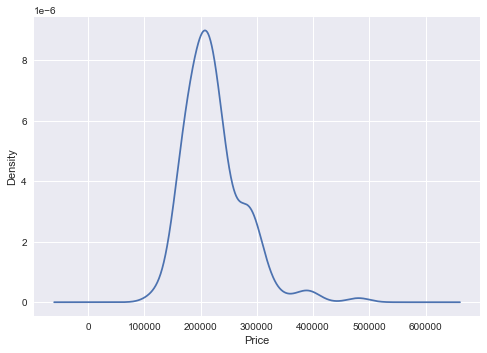

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

final_df.price[final_df.price < final_df.price.quantile(.99)].plot.kde()
plt.xlabel("Price");